# Quantification of tidal effects in Vietnam on Landsat satellite imagery 

Author: Ronja Lappe, 2020

Content of the script
- get sea level data for different stations in Vietnam 
- extract sea levels at Landsat aquisition time
- create date sequence for high tides and low tides respectively
- filter Landsat archive for dates at high and low tides with less than 20% cloud cover within the region of interest
- build low/ high tide pairs with closest aquisition dates 
- ...

Sea level data: 
http://uhslc.soest.hawaii.edu/data/?rq#uh381http://uhslc.soest.hawaii.edu/data/csv/rqds/pacific/hourly/h381a.csv

Available stations in Vietnam: 
- Qui Nhon, South-Central Vietnam (1994-2005, 2007-2018)
- Vung Tau, Southern Vietnam (1986-2002, 2007-2018)
- Hon Dau, Island in Northern Vietnam (1995)

### Setup

#### Python packages

In [12]:
import ee
import geemap
import geetools
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import datetime
import pytz
from pytz import timezone
import statistics as stat
import pickle
import warnings
import nbimporter
# my functions 
import utils

Importing Jupyter notebook from utils.ipynb


#### Parameters

In [24]:
# Sea level station 
station = "Qui Nhong" # name of station 
station_coordinates = [13.77500,109.25500] # coordinates of the station
local_timezone = "Asia/Ho_Chi_Minh" #for other options check: "pytz.all_timezones"

# Paths
station_file_name = "qui-nong1"
station_data_path = os.path.join(os.path.join(os.getcwd(),"input"))
output_path = os.path.join(os.getcwd(),"output")

Initiate Google Earth Engine

In [5]:
try:
    ee.Initialize()
    print('GEE initialized')
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

GEE initialized


In [13]:
try: 
    roi = utils.open_output(station_file_name+'_roi',output_path)
    print('File exists and has been loaded as:\nroi')
except:
    print('File not found. Interactively select your roi by uncommenting the next cell')

File not found. Interactively select your roi by uncommenting the next cell


In [10]:
# print interactive map
m1 = geemap.Map(center= station_coordinates,zoom=10)
m1

Map(center=[13.775, 109.255], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton…

In [16]:
# draw area of interest
try: 
    roi = utils.open_output(station_file_name+'_roi',output_path)
    print('File exists and has been loaded as:\nroi')
except:
    m1.draw_features
    roi = ee.FeatureCollection(m1.draw_features).geometry()
    utils.save_output(roi,station_file_name+'_roi',output_path)
    print('roi has been saved in directory.')

roi has been saved in directory.


## 1| Identification of low and high tide dates at Landsat aquisition time

#### 1.1| Functions 

In [38]:
def sea_level_prep(station_data):
    # read and clean sea level station data 
    station_data.columns = ['year','month','day','hour','sea_level'] # name columns
    station_data = station_data[station_data.sea_level >= 0] # remove all rows with sea level smaller zero
    return station_data

def get_valid_years(station_data):
    # remove entries with more than a thrid missing values 
    year_values = dict(station_data.year.value_counts())
    for key, value in dict(year_values).items():
            if value < 24*365/3:
                del year_values[key]
    years = list(year_values.keys())
    years.sort()
    print('Sea level station data available for the years',years,'at Station',station,',Vietnam.\n')
    return years

def select_landsat(year):
    #choose the right Landsat collection 
    if (year >= 1984) and (year <= 2011):
        ls_collection = "LANDSAT/LT05/C01/T1_SR"
    elif (year >= 2012) and (year <= 2013):
        ls_collection = "LANDSAT/LE07/C01/T1_SR"
    elif (year >= 2014) and (year <= 2020):
        ls_collection = "LANDSAT/LC08/C01/T1_SR"
    else:
        print("Choose year between 1984 and 2020")
    return ls_collection

def get_landsat_overpass_time(year, ls_collection, roi):
    # get a Landsat image for year and area of interest to extract the aquisition time
    ex_date1 = str(year)+"-01-01"
    ex_date2 = str(year)+"-12-31"   
    # filter Landsat archive
    ex_dataset = ee.ImageCollection(ls_collection)\
                      .filterDate(ex_date1, ex_date2)\
                      .filterBounds(roi)\
                      .filter(ee.Filter.lt('CLOUD_COVER',10))
    ex_list = ex_dataset.toList(10)
    try:
        # visualize example image
        ex_img = ee.Image(ex_list.get(0)).select(['B3', 'B2', 'B1']).clip(roi)
        # extract image properties 
        props = geemap.geemap.image_props(ex_img)
        props_info = props.getInfo()
        # get the Landsat aquisition time in GTM and convert to local time
        dt = props_info['system:time_start']
        dt_string = (dt[0:10]+" "+dt[11:19])
    except:
        dt_string = None
        print('       No Landsat imagery available.\n')
    return dt_string
        
def change_timezone(date_string, local_timezone):
        dt_object = datetime.datetime.strptime(date_string,"%Y-%m-%d %H:%M:%S")
        gmt = timezone("UTC") 
        dt_gmt = gmt.localize(dt_object)
        vietnam = timezone(local_timezone)
        dt_local = dt_gmt.astimezone(vietnam)
        return dt_local

# round time to nearest hour
def rounder(time):
    if time.minute >= 30:
        return time.replace(second=0, microsecond=0, minute=0, hour=time.hour+1)
    else:
        return time.replace(second=0, microsecond=0, minute=0)

def get_landsat_aquisition_hour(local_time, year):
    dt_round = rounder(local_time)
    t = local_time.strftime("%H:%M:%S")
    t_round = dt_round.hour    
    return t_round

def get_sea_level_at_landsat_aquisition(sea_level_data, aquisition_time, year):
     # read and filter sea level station data
    sea_level_year = sea_level_data[(sea_level_data.year==year)]
    #station_yoi = station_data[(station_data.year>=2007)&(station_data.year <=2008)]
    sea_level_landsat= sea_level_year[(sea_level_year.hour == aquisition_time)].reset_index(drop=True)
    doys = []
    dates = []
    for i, row in enumerate(sea_level_landsat.iterrows()):
        date = datetime.date(sea_level_landsat.iloc[i].year,sea_level_landsat.iloc[i].month,sea_level_landsat.iloc[i].day)
        doy = date.timetuple().tm_yday
        dates.append(date)
        doys.append(doy)
    sea_level_landsat['doy']=doys
    sea_level_landsat['date']=dates
    return sea_level_landsat 

def get_tide_doys(sea_level_data, min_distance, tide):
     # find peaks of high tide
    if tide == 'high':   
        peaks = find_peaks(sea_level_data.sea_level,distance=min_distance)
    elif tide == 'low':
        reverse_peaks = sea_level_data.sea_level*-1
        peaks = find_peaks(reverse_peaks,distance=min_distance)
    else:
        print('Select either high or low tide.')
    peaks = list(peaks[0])
    # add day before and after hightest tide
    indices = []
    for i in peaks:
        if i+1 < len(sea_level_data) and i-1 > 0:
            i = int(i)
            indices.append(i)
            indices.append(i-1)        
            indices.append(i+1)
    doys = []
    for i in indices:
        doys.append(sea_level_data.doy.iloc[i])
    return indices,doys 

def doys_to_dates(sea_level_data, doys):
    dates = []
    for i in doys:
        #date = str(datetime.date(sea_level_data.iloc[i].year,sea_level_data.iloc[i].month,sea_level_data.iloc[i].day))
        date = np.array(sea_level_data.loc[sea_level_data['doy'] == i].date)[0]
        dates.append(str(date))
    dates.sort()
    return dates

def plot_peaks(sea_level_data, high_tide_indices, low_tide_indices,save_plot=False):
    # plot sea level graph 
    warnings.filterwarnings("ignore", category=FutureWarning)
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(figsize = (25,5))
    p = sns.lineplot(ax=ax,
                    x=sea_level_data.doy,
                    y=sea_level_data.sea_level,
                    lw = 2,
                    marker = "o",
                    markerfacecolor='red',
                    markevery=[high_tide_indices]
                    )
    p = sns.lineplot(ax=ax,
                    x=sea_level_data.doy,
                    y=sea_level_data.sea_level,
                    lw = 0,
                    marker = "o",
                    markerfacecolor='green',
                    markevery=[low_tide_indices]
                    )    
    locs, labels = plt.xticks()
    plt.xticks(np.arange(0,365, step=5))
    plt.title("{}{}{}{}{}{}{}".format("Sea level at ",station, " station \n",year," at ",aquisition_hour," (appr. aquisition time for Landsat)"),
             fontsize=15)
    plt.ylabel("Sea level [mm]")
    plt.xlabel("DOY")
    if save_plot == True:
        if not os.path.exists(os.path.join(output_path,'figures')):
            os.makedirs(os.path.join(output_path,'figures'))
        plt.savefig(os.path.join(output_path,'figures','Sea_levels_'+station_file_name+'_'+str(year)))

#### 1.2| Main

Files not found, processing started...
Sea level station data available for the years [1994, 1995, 1996, 2000, 2003, 2004, 2005] at Station Qui Nhong ,Vietnam.

1994 : LANDSAT/LT05/C01/T1_SR has been selected
       Landsat images for roi aquired at 1994-04-06 09:20:56+07:00 local time.
       Hence, sea level data at 9 h is selected.

1995 : LANDSAT/LT05/C01/T1_SR has been selected
       Landsat images for roi aquired at 1995-04-09 09:09:53+07:00 local time.
       Hence, sea level data at 9 h is selected.

1996 : LANDSAT/LT05/C01/T1_SR has been selected
       Landsat images for roi aquired at 1996-03-26 09:08:44+07:00 local time.
       Hence, sea level data at 9 h is selected.

2000 : LANDSAT/LT05/C01/T1_SR has been selected
       Landsat images for roi aquired at 2000-04-22 09:35:40+07:00 local time.
       Hence, sea level data at 10 h is selected.

2003 : LANDSAT/LT05/C01/T1_SR has been selected
       No Landsat imagery available.

2004 : LANDSAT/LT05/C01/T1_SR has been selec

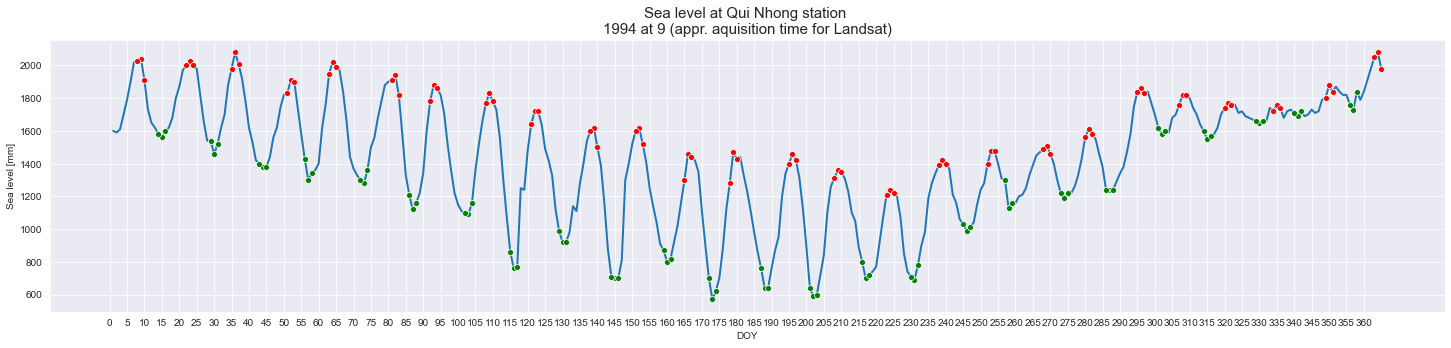

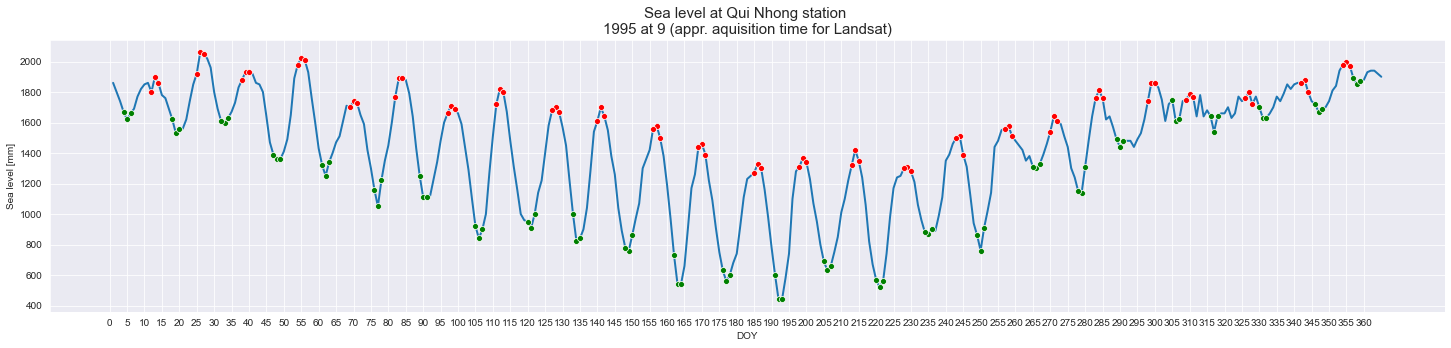

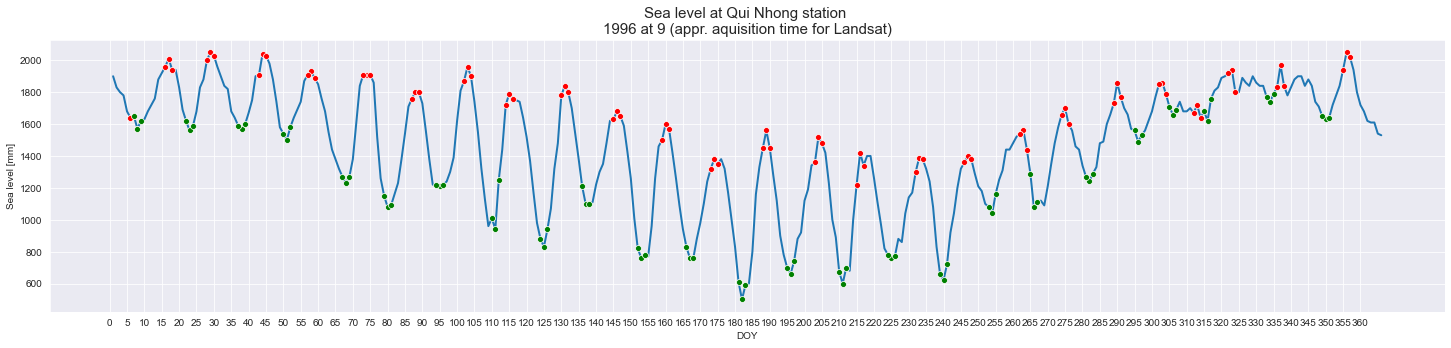

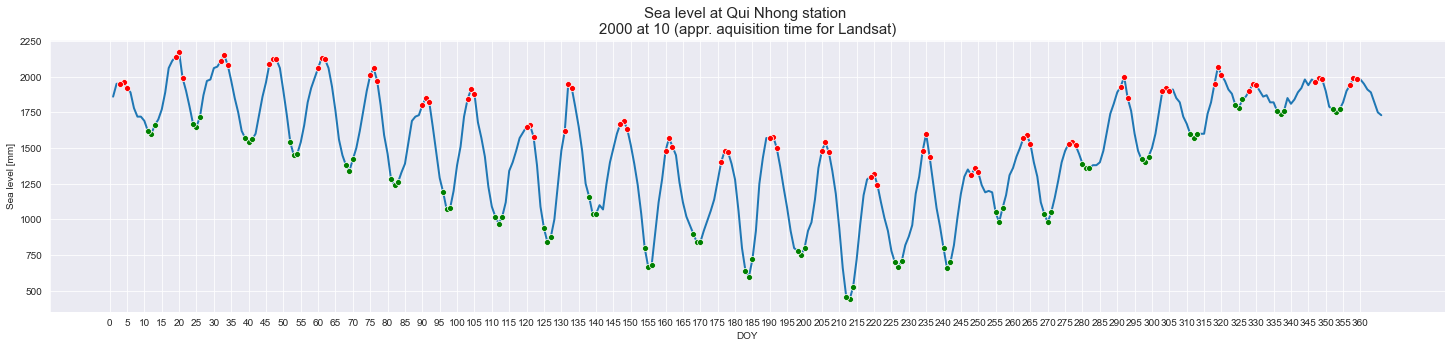

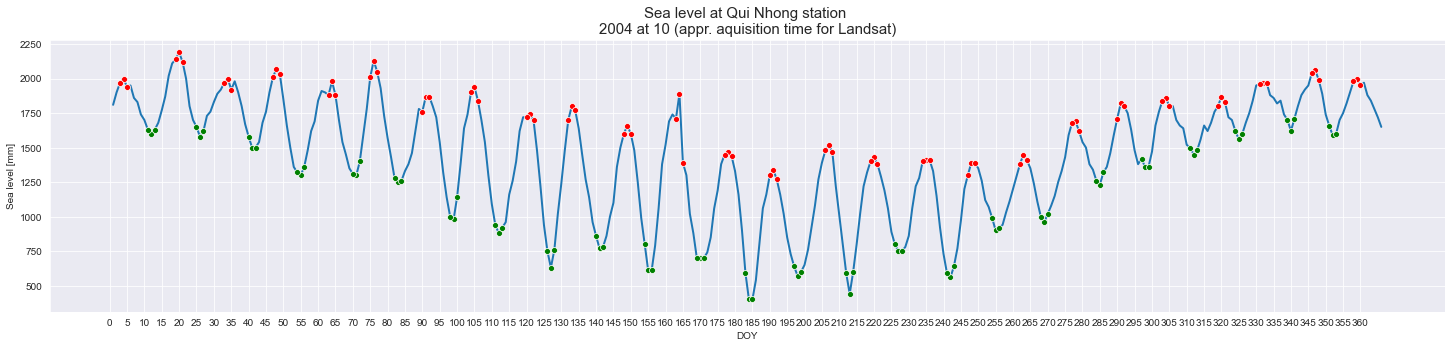

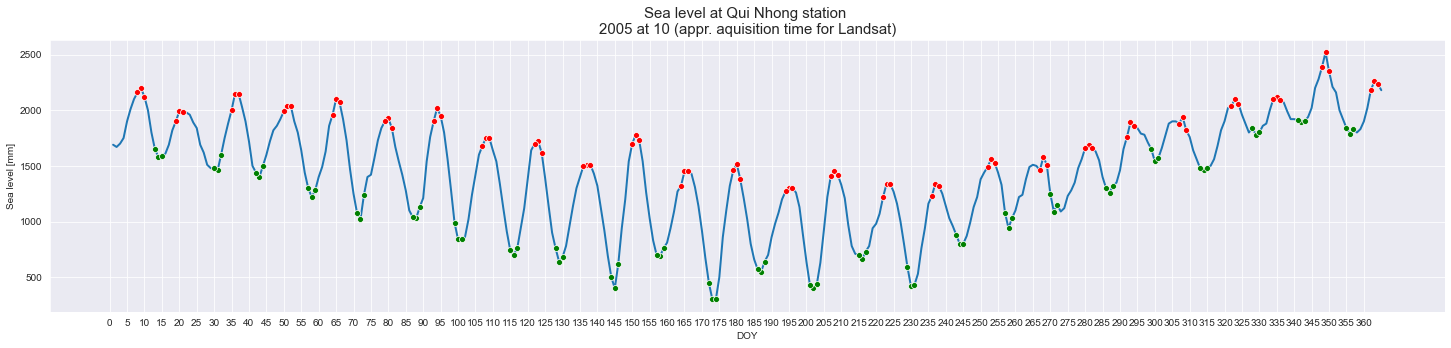

In [39]:
try:
    high_tide_dates = utils.open_output(station_file_name+'_high_tide_dates', output_path)
    low_tide_dates = utils.open_output(station_file_name+'_low_tide_dates', output_path)
    years_left = utils.open_output(station_file_name+'_years_left', output_path)
    print('Files exist and have been loaded as:\nhigh_tide_dates\nlow_tide_dates\nyears_left')
except:
    print('Files not found, processing started...')
    # output of main script will be saved in two lists:
    high_tide_dates = []
    low_tide_dates = []
    years_left = []

    # read and clean sea level station data
    sl_station_data  = pd.read_csv(os.path.join(station_data_path,station_file_name+".csv")) # read csv
    sl_station_data = sea_level_prep(sl_station_data)
    # create a list of years for which sea level data is available 
    years = get_valid_years(sl_station_data)
    # loop through available years to extract high- and low tide landsat images
    for i in years:
        year = i
        # select landsat sensor for each year
        ls_collection = select_landsat(year)
        print(year,':',ls_collection, 'has been selected')
        # get landsat overpass time within region of interest for each year
        overpass_time = get_landsat_overpass_time(year,ls_collection,roi)

        if overpass_time is not None:
        # change to local time zone 
            years_left.append(i)
            local_time = change_timezone(overpass_time,local_timezone)
            print('       Landsat images for roi aquired at',local_time,'local time.')
            # round local time to closest full hour (since only hourly sea level data is available)
            aquisition_hour = get_landsat_aquisition_hour(local_time,year)
            print('       Hence, sea level data at', aquisition_hour, 'h is selected.\n')
            # filter sea level data by year and landsat aquisition hour
            sea_level_landsat = get_sea_level_at_landsat_aquisition(sl_station_data, aquisition_hour,year)
            # identify doys of landsat aquisition at high tides (+/- 1)
            ht_doys = get_tide_doys(sea_level_landsat,10,'high')
            # identify doys of landsat aquisition at low tides (+/- 1)
            lt_doys = get_tide_doys(sea_level_landsat,10,'low')
            # convert doys to dates 
            ht_dates = doys_to_dates(sea_level_landsat,ht_doys[1])
            high_tide_dates.append(ht_dates)
            lt_dates = doys_to_dates(sea_level_landsat,lt_doys[1])
            low_tide_dates.append(lt_dates)
            # plot a chart with sea levels at Landsat aquisition time for each year with marked high and low tides
            plot_peaks(sea_level_landsat, ht_doys[0], lt_doys[0], save_plot=True) # I should save the plots at one point :)
    # save date_lists
    utils.save_output(high_tide_dates,station_file_name+'_high_tide_dates', output_path)
    utils.save_output(low_tide_dates,station_file_name+'_low_tide_dates', output_path)
    utils.save_output(years_left,station_file_name+'_years_left', output_path)